From: https://arxiv.org/pdf/2302.04703 and https://github.com/joshspeagle/nrp_astrobayes

# Parallaxes

We infer the distance to a star from a parallax measurement. The true but unknown distance d in kiloparsecs (kpc) is related to the true but unknown parallax π in milliarcseconds (mas) through

$$d [\rm{kpc}] = \frac{1}{π} [\rm {mas}].$$

Our data y is a measurement of the parallax, and has some fixed uncertainty σ that we treat as known. Thus, in the Bayesian framework,
we wish to infer the parameter d given the data y, and we seek to find the posterior distribution,

$$ p(d|y) \sim p(y|d)p(d).$$

Later, we extend this example to infer the distance to a
star cluster from the parallax measurements of many stars within
the cluster.

## Preamble

Just setting up some basic commands and plotting environment style.

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

In [2]:
# fix random seed to ensure exact reproducibility
np.random.seed(2021)

# Data

Load in the data.

In [3]:
# load data for NGC 2682 (M67) star cluster
hdu = fits.open('NGC_2682.fits')
data = hdu[1].data

# extract membership probabilities from kinematics (Gaia DR2)
pmem = data['HDBscan_MemProb']

# extract parallaxes (Gaia DR2)
# note: no corrections have been applied for any systematics
p, pe = data['Parallax'], data['Parallax_Err']

In [4]:
# get lowest SNR parallax
idx_min = np.argmin(p/pe)

## Likelihood

$$p(y|d) = \frac{1}{\sqrt{2πσ^2}} e^{-\frac{(y − 1/d)^2}{2σ^2}}$$

or equivalently, $y|d$, $σ \sim N(1/d,σ^2)$.

In [8]:
# Let's simulate some data. Deliberately shift mean and inflate errors for illustrative purposes of the likeliood
pdraws = np.random.normal(p[idx_min] - 0.5, pe[idx_min] * 3, size=int(1e8))

## Prior

We'll illustrate the impact of various priors on the likelihood using a series of random draws.

In [10]:
# prior 1: uniform in parallax, we just define minimum and maximum parallaxes.
prior_unif_parallax = np.random.uniform(0, 5, size=int(1e8))

# prior 2: uniform in distance
prior_unif_dist = np.random.uniform(0, 10, size=int(1e8))

In [11]:
# histogram our data in both parallax and distance

# prior 1: uniform in parallax
y, bins_p = np.histogram(pdraws, bins=np.linspace(-4, 5, 2501))
cents_p = (bins_p[1:] + bins_p[:-1]) / 2.
yp_par, _ = np.histogram(prior_unif_parallax, bins=bins_p)
yp_dist, _ = np.histogram(1. / prior_unif_dist, bins=bins_p)

# prior 2: uniform in distance
y2, bins_d = np.histogram(1./pdraws, bins=np.linspace(0, 10, 2501))
cents_d = (bins_d[1:] + bins_d[:-1]) / 2.
y2p_par, _ = np.histogram(1. / prior_unif_parallax, bins=bins_d)
y2p_dist, _ = np.histogram(prior_unif_dist, bins=bins_d)

While the prior for distance above may appear non-informative (in a sense that it is uniform), it actually encodes a strong assumption about the number density of stars ρ as a function of distance. The prior implies that we are just as likely to observe stars at large distances as we are at smaller distances. However, as we look out into space, the area of the solid angle defined by the distance d increases, and this in turn implies that the stellar number density is decreasing with
distance.

[Bailer-Jones et al. (2018)](https://iopscience.iop.org/article/10.3847/1538-3881/aacb21) introduced a better prior for the parallax inference problem.

The physical volume dV probed by an infinitesimal solid angle on the sky dΩ at a given distance d scales as the size of a shell so that dΩ $\propto$ d$^2$. This means that, assuming a constant stellar number density ρ everywhere, a prior behaving as p(d) $\propto$ d$^2$ is more appropriate.

However, we know that our Sun sits in the disk of the Galaxy, and that the actual stellar density ρ as we go radially outward in the disk should decrease as a function of distance. Assuming we are looking outward, and that the stellar density decreases exponentially with a length scale L (so that for a
given distance we have p(ρ|d) $\propto$ e$^{−d/L}$ the prior on distance is:

$$ p(d) \propto \begin{cases}
d^2 e^{−d/L} & d_{\rm min} < d < d_{\rm max}\\
0 & {\rm otherwise}
\end{cases}
$$

which is the density function of a truncated Gamma(3, L) distribution.

In [12]:
# prior 3: EDSD (Bailer-Jones et al. 2018)

# compute function over corresponding bins
y3 = cents_d**2 * np.exp(-cents_d / 1.)
y3 /= y3.sum()

# use inverse-CDF sampling to draw from prior
y3p_draws = np.interp(np.random.uniform(0, 1, size=int(1e8)), y3.cumsum(), cents_d)

# histogram data
y3p_par, _ = np.histogram(1. / y3p_draws, bins=bins_p)
y3p_dist, _ = np.histogram(y3p_draws, bins=bins_d)

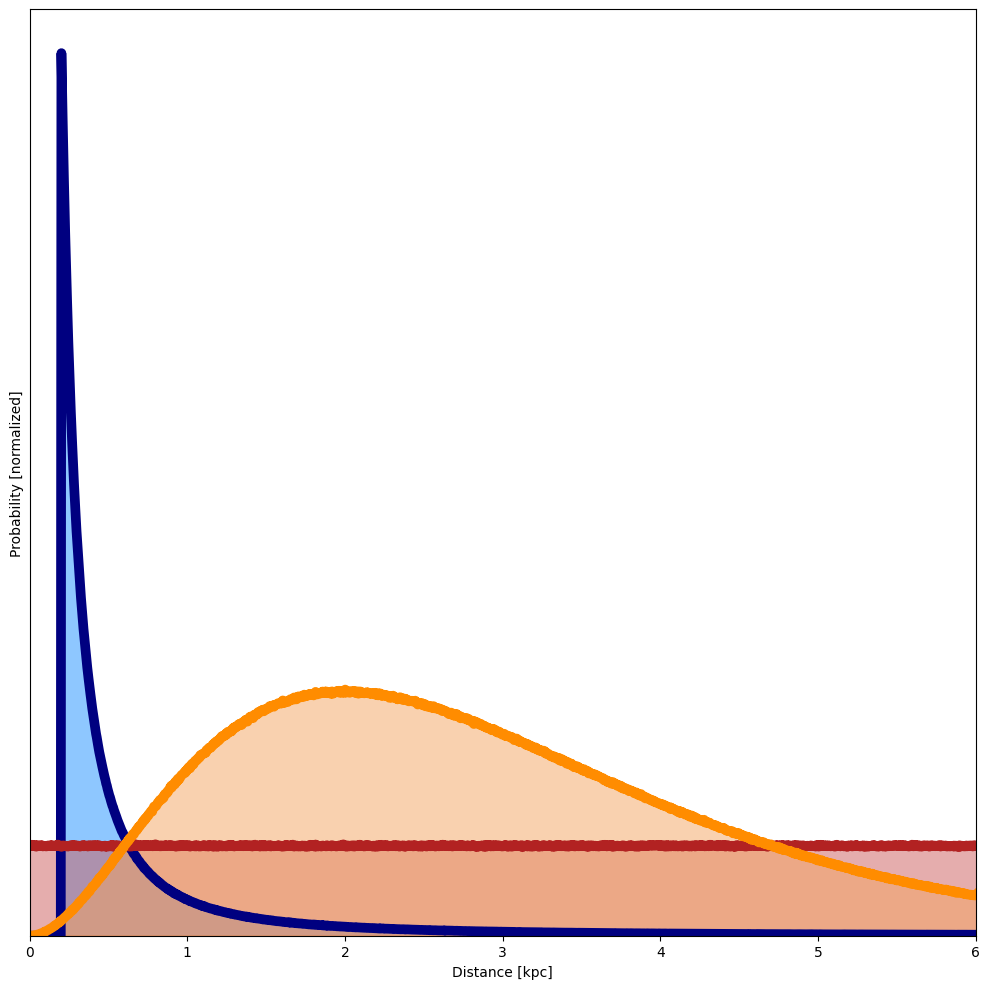

In [13]:
# plot priors (distance)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par / 5., color='dodgerblue', alpha=0.5)
plt.plot(cents_d, y2p_par / 5., color='navy', lw=7)
plt.fill_between(cents_d, y2p_dist, color='indianred', alpha=0.5)
plt.plot(cents_d, y2p_dist, color='firebrick', lw=7)
plt.fill_between(cents_d, y3p_dist, color='sandybrown', alpha=0.5)
plt.plot(cents_d, y3p_dist, color='darkorange', lw=7)
plt.xlim([0, 6])
plt.xlabel('Distance [kpc]')
plt.ylim([0, None])
plt.yticks([])
plt.ylabel('Probability [normalized]')
plt.tight_layout()
#plt.savefig('priors_lowsnr.png', bbox_inches='tight')

## Posterior distribution

The posterior distribution is the focus of Bayesian
inference. Once the prior distribution(s) and the likelihood function
are specified, the posterior distribution is uniquely determined. Often, the denominator quantity p(y) is not available analytically. In this case, p(y) can be estimated by numerical integration.

The posterior distribution enables inference of model parameters
or of quantities that can be derived from model parameters. For
example, the posterior mean E(θ | y) is a point summary for θ. The
posterior distribution can also be used to define credible intervals
for parameters that provide a range of probable values.

We stress that credible intervals are not confidence intervals; a 95% credible interval suggests that there is a 95% probability that the parameter lies within the specified range given our prior beliefs, the model, and the data, whereas a 95% confidence interval suggests that if similar intervals are properly constructed for multiple datasets then 95% of them are expected to contain the true (fixed) parameter value.

The posterior distribution also provides a useful way to obtain estimates and credible intervals for other quantities of physical interest.cFor example, if a model has parameters $θ = (α, β, κ)$ and there is some physical quantity described by e.g., $γ = β^2 /αe^κ$, then for every sample of $θ$, a sample of $γ$ can be calculated. Thus, a distribution of the physically interesting quantity $γ$ is obtained, which can also be used to obtain point estimates and credible intervals.

In our running example, we are interested in inferring the parameter
for the distance $d = 1/π$ given the measured parallax $y$ and its
associated measurement uncertainty $σ$ (which we treat as known).

As we know, from Bayes’ theorem, the posterior is:

$$p(d|y) \sim p(y|d)p(d).$$

For the three priors discussed previously, this corresponds to the
following posteriors:

* Uniform parallax:
$$
p(d|y) \sim \frac{1}{d^2} e^{−\frac{(y − 1/d)^2}{2σ^2}}.
$$

* Uniform distance:
$$
p(d|y) \sim e^{−\frac{(y − 1/d)^2}{2σ^2}}.
$$

* Bailer-Jones:
$$
p(d|y) \sim d^2 e^{−\frac{d}{L}-\frac{(y − 1/d)^2}{2σ^2}}.
$$

for $d_{\rm min} < d < d_{\rm max}$ (and 0 otherwise). While none of these have analytic solutions for point estimates or credible intervals, they can be computed using computational techniques.

Let's not forget that if $f$ is uniformly distributed the PDF of the reciprocal, $y=1/f$, is $\sim \frac{1}{y^2}$.

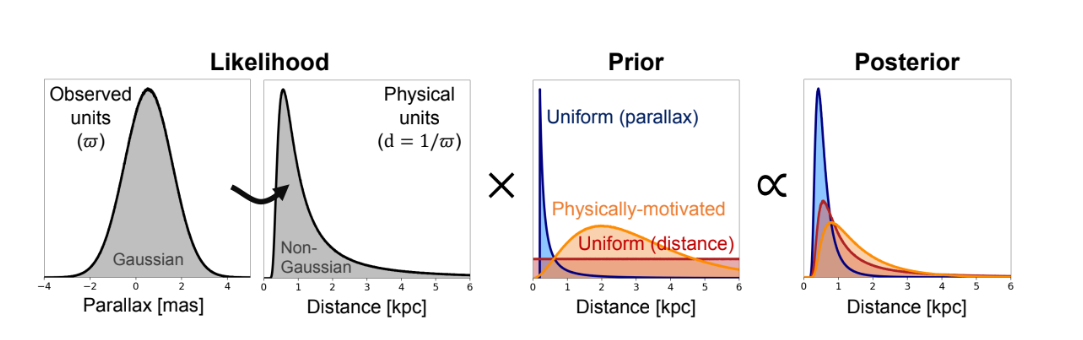


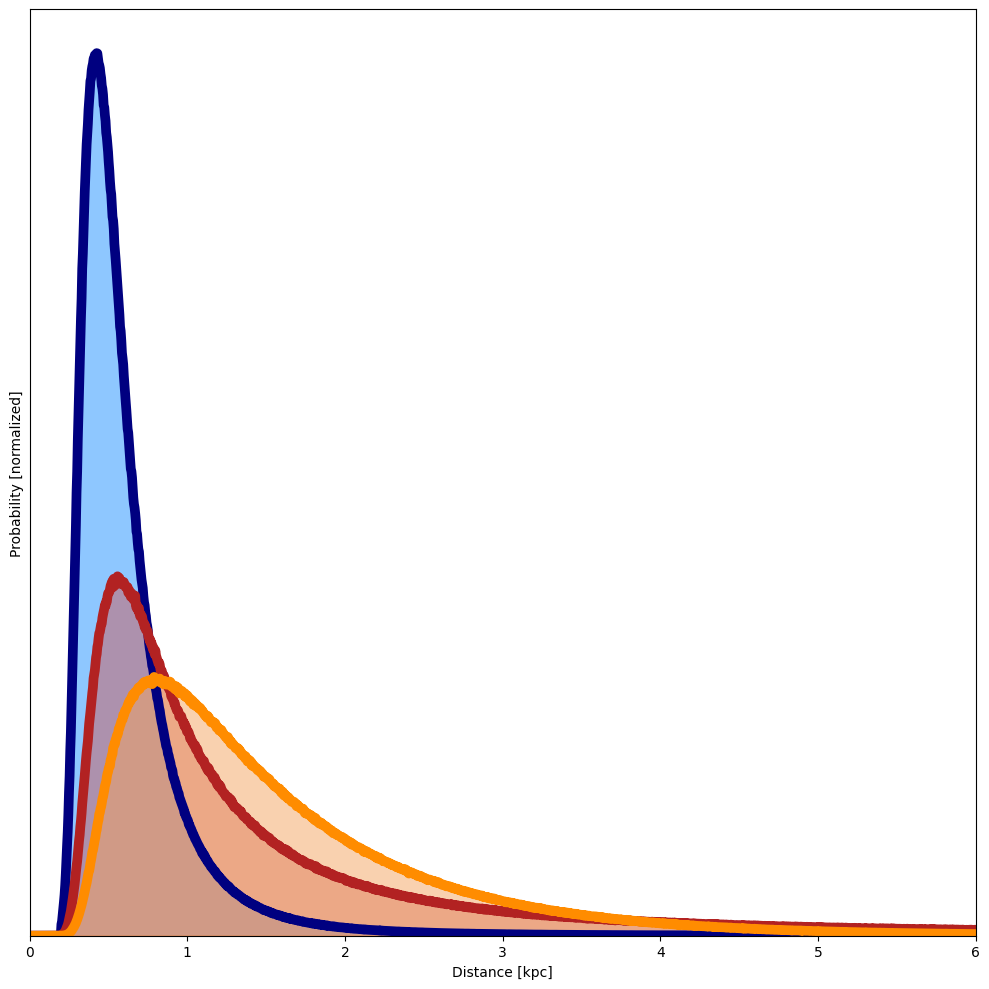

In [14]:
# plot posteriors (distance)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='dodgerblue', alpha=0.5)
plt.plot(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='navy', lw=7)
plt.fill_between(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='indianred', alpha=0.5)
plt.plot(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='firebrick', lw=7)
plt.fill_between(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='sandybrown', alpha=0.5)
plt.plot(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='darkorange', lw=7)
plt.xlim([0, 6])
plt.xlabel('Distance [kpc]')
plt.ylim([0, None])
plt.ylabel('Probability [normalized]')
plt.yticks([])
plt.tight_layout()
#plt.savefig('posteriors_lowsnr.png', bbox_inches='tight')

## Summary Statistics

Using our previous posteriors, we'll highlight a few summary statistics.

In [ ]:
# compute median and 95% CIs
y2p_par_med = cents_d[np.argmin(np.abs(np.cumsum(y2p_par * y2 / sum(y2p_par * y2)) - 0.5))]
y2p_par_ci = [cents_d[np.argmin(np.abs(np.cumsum(y2p_par * y2 / sum(y2p_par * y2)) - ci))]
              for ci in [0.05, 0.95]]
y2p_dist_med = cents_d[np.argmin(np.abs(np.cumsum(y2p_dist * y2 / sum(y2p_dist * y2)) - 0.5))]
y2p_dist_ci = [cents_d[np.argmin(np.abs(np.cumsum(y2p_dist * y2 / sum(y2p_dist * y2)) - ci))]
               for ci in [0.05, 0.95]]
y3p_dist_med = cents_d[np.argmin(np.abs(np.cumsum(y3p_dist * y2 / sum(y3p_dist * y2)) - 0.5))]
y3p_dist_ci = [cents_d[np.argmin(np.abs(np.cumsum(y3p_dist * y2 / sum(y3p_dist * y2)) - ci))]
               for ci in [0.05, 0.95]]
print('Posterior 1:', y2p_par_med, y2p_par_ci)
print('Posterior 2:', y2p_dist_med, y2p_dist_ci)
print('Posterior 3:', y3p_dist_med, y3p_dist_ci)

# compute modes
y2p_par_mode = cents_d[np.argmax(y2p_par * y2)]
y2p_dist_mode = cents_d[np.argmax(y2p_dist * y2)]
y3p_dist_mode = cents_d[np.argmax(y3p_dist * y2)]
print('Modes:', y2p_par_mode, y2p_dist_mode, y3p_dist_mode)

Posterior 1: 0.526 [0.302, 1.286]
Posterior 2: 0.998 [0.402, 5.1579999999999995]
Posterior 3: 1.274 [0.51, 3.542]
Modes: 0.41800000000000004 0.562 0.778


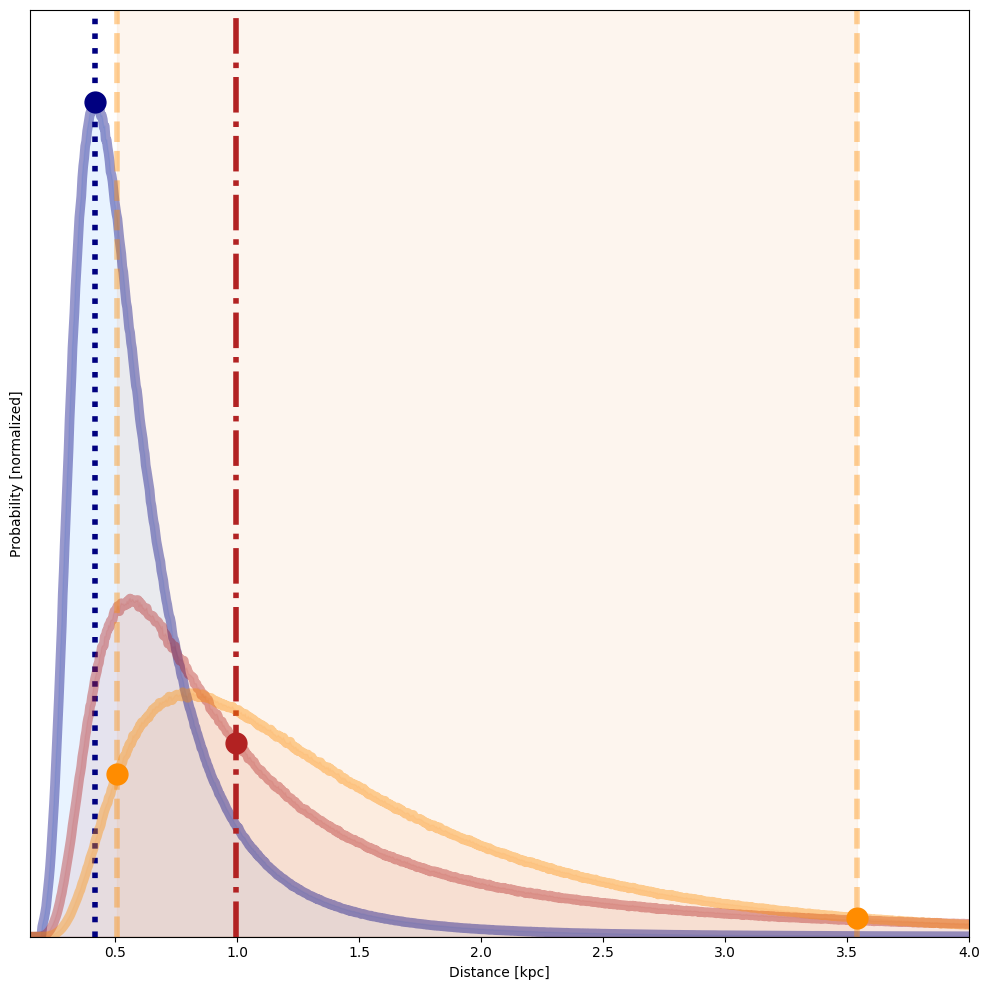

In [ ]:
# zoomed-in version w/ median and CIs
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='dodgerblue', alpha=0.1)
plt.plot(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='navy', lw=7, alpha=0.4)
plt.vlines(y2p_par_mode, 0, 1, color='navy', lw=4, ls='dotted')
plt.plot(y2p_par_mode, np.interp(y2p_par_mode, cents_d, y2p_par * y2 / sum(y2p_par * y2)),
         color='navy', marker='o', markersize=15)
plt.fill_between(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='indianred', alpha=0.1)
plt.plot(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='firebrick', lw=7, alpha=0.4)
plt.vlines(y2p_dist_med, 0, 1, color='firebrick', lw=4, ls='-.')
plt.plot(y2p_dist_med, np.interp(y2p_dist_med, cents_d, y2p_dist * y2 / sum(y2p_dist * y2)),
         color='firebrick', marker='o', markersize=15)
plt.fill_between(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='sandybrown', alpha=0.1)
plt.plot(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='darkorange', lw=7, alpha=0.4)
plt.fill_between(y3p_dist_ci, 0, 1, color='sandybrown', alpha=0.1)
plt.vlines(y3p_dist_ci, 0, 1, color='darkorange', lw=4, ls='--', alpha=0.4)
plt.plot(y3p_dist_ci, np.interp(y3p_dist_ci, cents_d, y3p_dist * y2 / sum(y3p_dist * y2)),
         color='darkorange', marker='o', markersize=15, ls='none')
plt.xlim([0.15, 4.0])
plt.xlabel('Distance [kpc]')
plt.ylim([0, 1e-2])
plt.ylabel('Probability [normalized]')
plt.yticks([])
plt.tight_layout()
#plt.savefig('posteriors_lowsnr_zoom.png', bbox_inches='tight')

## Cluster (M67) distance

We now extend our example to infer the distance to a cluster of
stars, based on the collection of parallax measurements of each individual star. Assuming that there are n stars located at approximately the same distance $d_{\rm cluster}$ and that the measured parallaxes $y = {y_1, y_2, . . . , y_n}$ to each star are independent given $d_{\rm cluster}$.

The combined likelihood is the product of the individual likelihoods:

$$p(y_1, y_2, . . . , y_n|1/d_{\rm cluster}) = \prod_{i=1}^{n} p(y_i |1/d_{\rm cluster}),$$

and again we assume that the measurement uncertainties $σ_i$ are known constants.

Our posterior then is:

$$p(d_{\rm cluster}|y) \sim p(d_{\rm cluster}) \prod_{i=1}^{n} p(y_i |1/d_{\rm cluster}).$$

The product of $n$ independent Gaussian densities with known variances is a Gaussian density with precision parameter $τ^{−2} =
\sum^n_{i=1} σ_i^{−2}$ and mean parameter $1/d_{\rm cluster}$.
This means the observed parallaxes can be combined to obtain an effective parallax $y_{eff} = τ^2 \sum^n_{i=1} y_i/σ^2_i$.

Then:

$$p(d_{\rm cluster}|y) \sim p(d_{\rm cluster}) e^{-\frac{(y_{\rm eff}− 1/d_{\rm cluster})^2}{2τ^2}}.$$

The estimated posterior distribution over $π_{\rm cluster} = 1/d_{\rm cluster}$ for M67, using data from Gaia DR2, and using
a conjugate Gaussian prior for $π_{\rm cluster}$, is shown below.


In [15]:
# sort data in ascending SNR
idx_asc = np.argsort(p/pe)

# shuffle order (unordered results)
#np.random.shuffle(idx_asc)

# apply membership probability cutoff
sel = idx_asc[pmem[idx_asc] > 0.3]

# define Gaussian prior
prior_mean, prior_std = np.full_like(p[sel], 1.2), np.full_like(p[sel], 0.1)

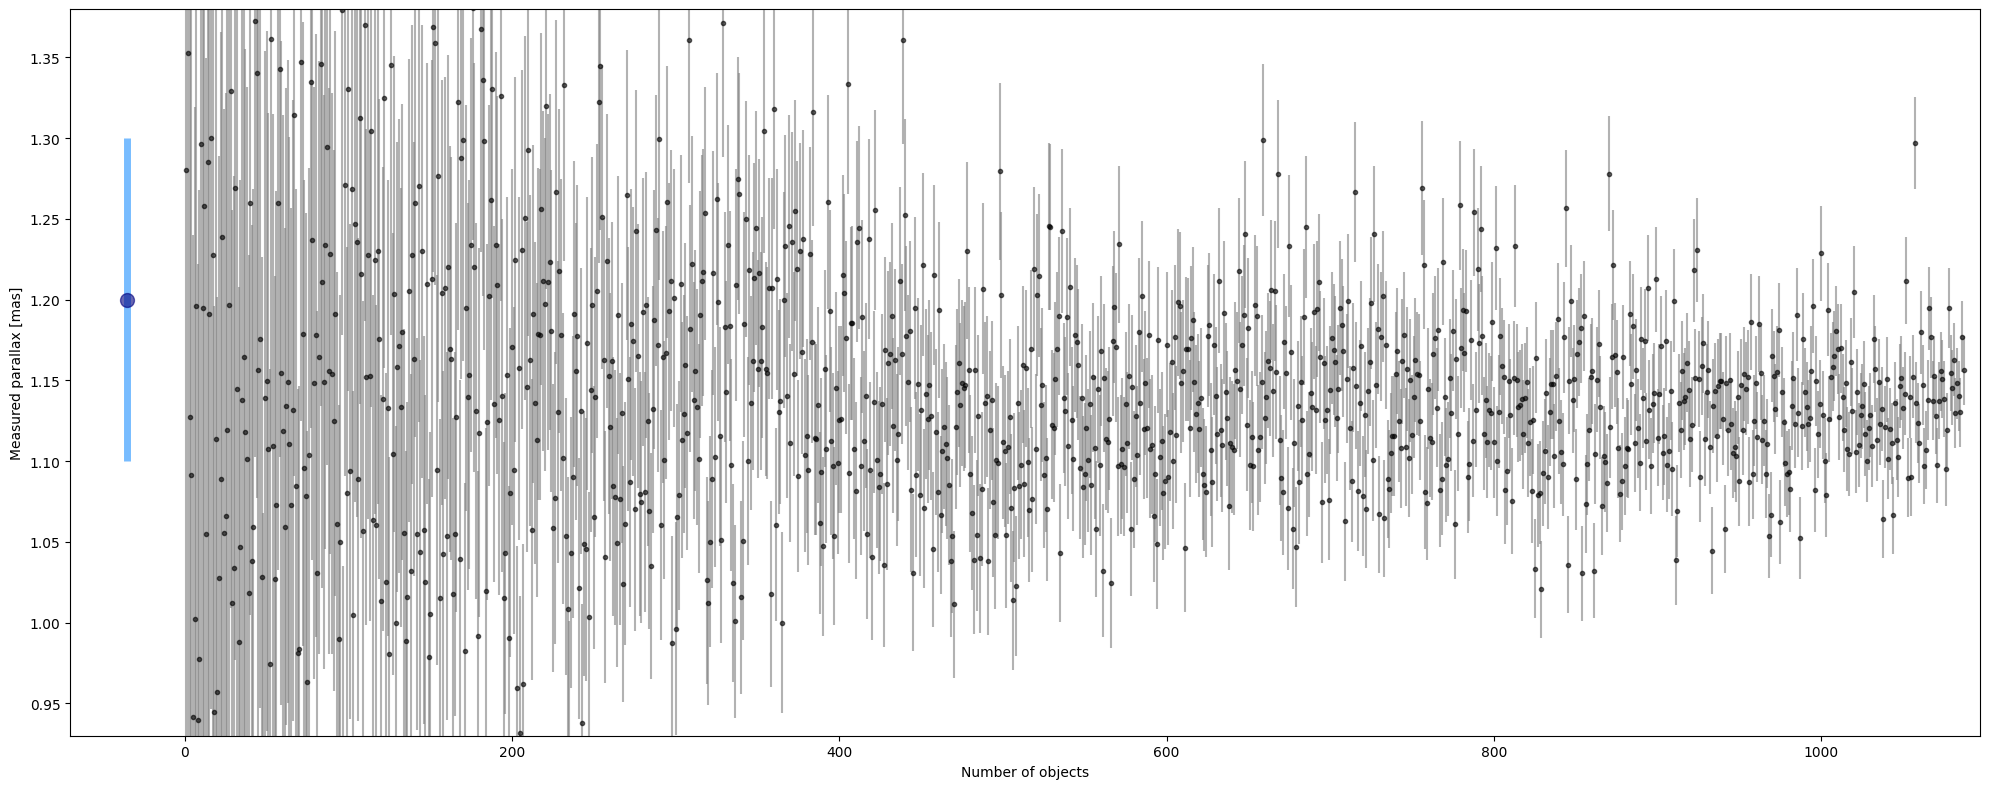

In [ ]:
# plot prior and measurements
plt.figure(figsize=(20, 8))
plt.errorbar(np.arange(1, len(sel) + 1), p[sel], yerr=pe[sel],
             linestyle='none', ecolor='gray', alpha=0.6, marker='.', color='black')
plt.errorbar(-35, prior_mean[0], yerr=prior_std[0],
             linestyle='none', ecolor='dodgerblue', alpha=0.6, marker='o', markersize=10, lw=5, color='navy')
plt.xlim([-70, len(sel) + 10])
plt.xlabel('Number of objects')
plt.ylim([0.93, 1.38])
plt.ylabel('Measured parallax [mas]')
plt.tight_layout()
#plt.savefig('data_ind.png', bbox_inches='tight')

The figure above shows the individual parallax measurements
of stars in M67, sorted by their signal-to-noise values. Please note that a prior over $p(d_{\rm cluster})$, which governs the distribution of clusters of stars, is not the same as a prior over $p(d)$, which governs the distribution of individual stars. While it might be reasonable to assume these are similar, they are not interchangeable quantities and may indeed follow different distributions.

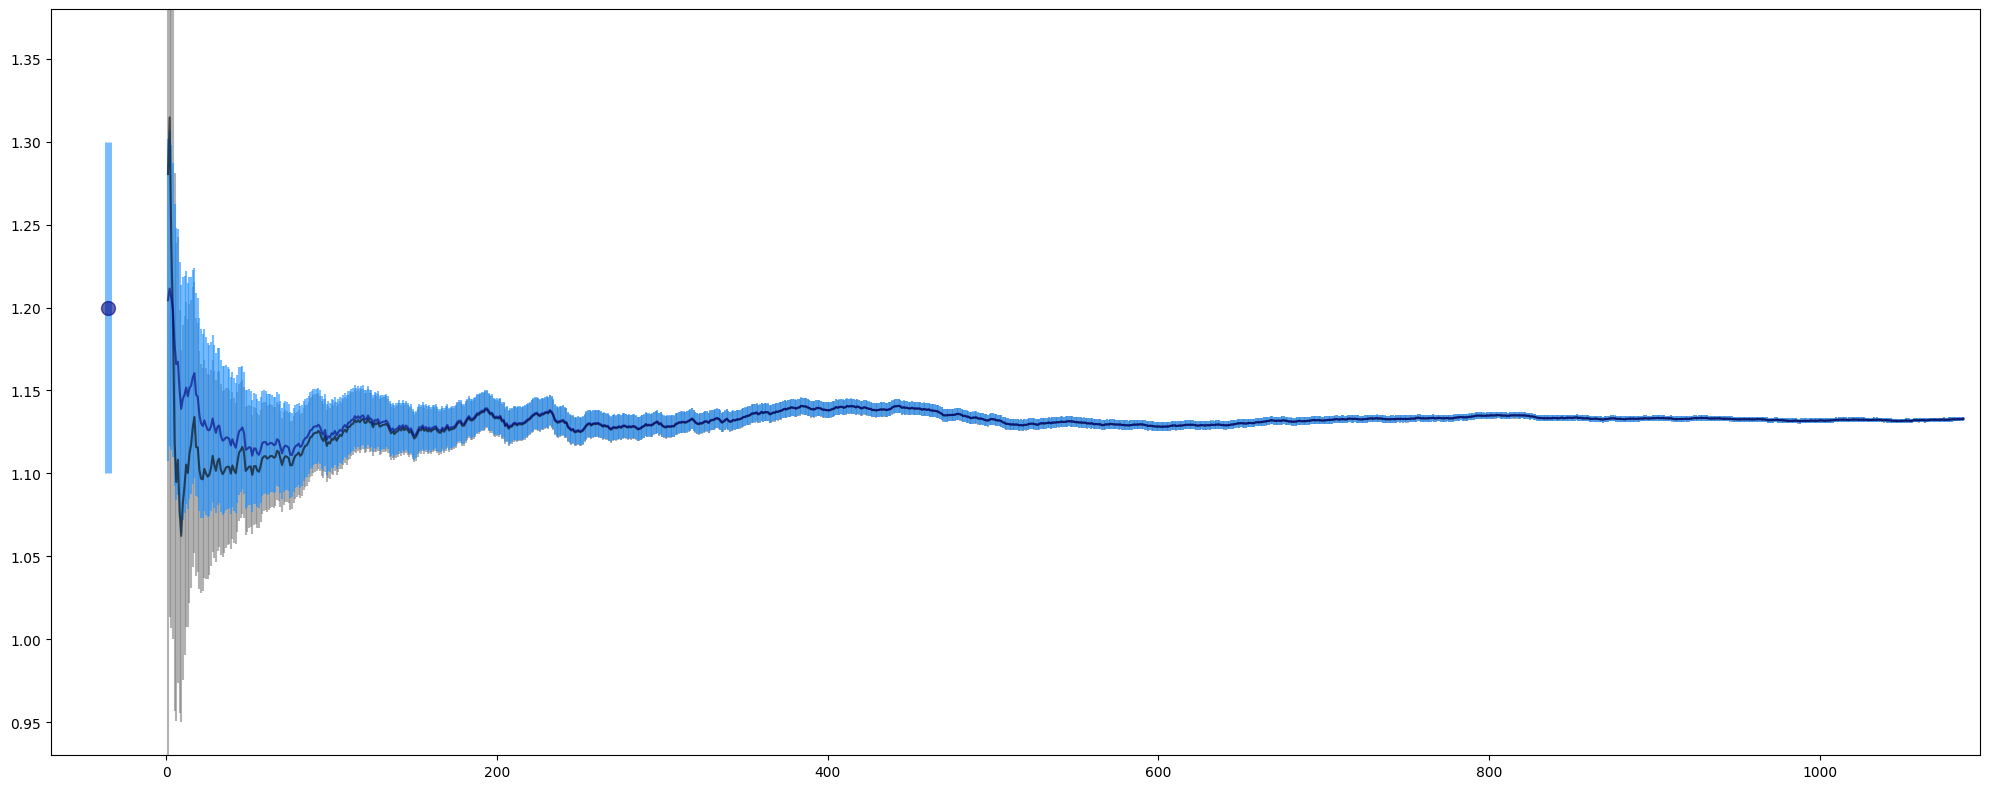

In [ ]:
# compute joint likelihood as we sequentially add more data
wivar = np.cumsum(1. / pe[sel]**2)
wmean = np.cumsum(p[sel] / pe[sel]**2) / wivar

# compute joint posterior as we add more data
wivar_post = wivar + 1. / prior_std**2
wmean_post = (wmean * wivar + prior_mean / prior_std**2) / wivar_post

# plot prior, joint likelihood, and joint posterior
plt.figure(figsize=(20, 8))
plt.errorbar(-35, prior_mean[0], yerr=prior_std[0],
             linestyle='none', ecolor='dodgerblue', alpha=0.6, marker='o', markersize=10, lw=5, color='navy')
plt.errorbar(np.arange(1, len(sel) + 1), wmean, yerr=wivar**-0.5,
             ecolor='gray', alpha=0.6, color='black')
plt.errorbar(np.arange(1, len(sel) + 1), wmean_post, yerr=wivar_post**-0.5,
             ecolor='dodgerblue', alpha=0.6, color='navy')
plt.xlim([-70, len(sel) + 10])
#plt.xlabel('Number of objects')
plt.ylim([0.93, 1.38])
#plt.xlabel('Inferred Parallax [mas]')
plt.tight_layout()
#plt.savefig('data_likepost2.png', bbox_inches='tight')

## Posterior predictive checks

We now investigate the validity of our model for the distance to a cluster of stars by computing the posterior predictive distribution for the observed stellar parallaxes.

Please note thta, in principle, in this case the posterior predictive
can be written in closed form (since it is a Gaussian distribution). However, we choose to approximate it by simulating values of d$_{\rm cluster}$ from the posterior and then subsequently simulating values for the predicted parallax measurements $π_{{\rm pred},i}$ given d$_{\rm cluster}$.

In [ ]:
# generate data realization from posterior
p_post = np.random.normal(wmean_post[-1], wivar_post[-1]**-0.5, size=len(sel))

# generate data realization (sample) from posterior predictive
p_postpred = np.random.normal(p_post, pe[sel])

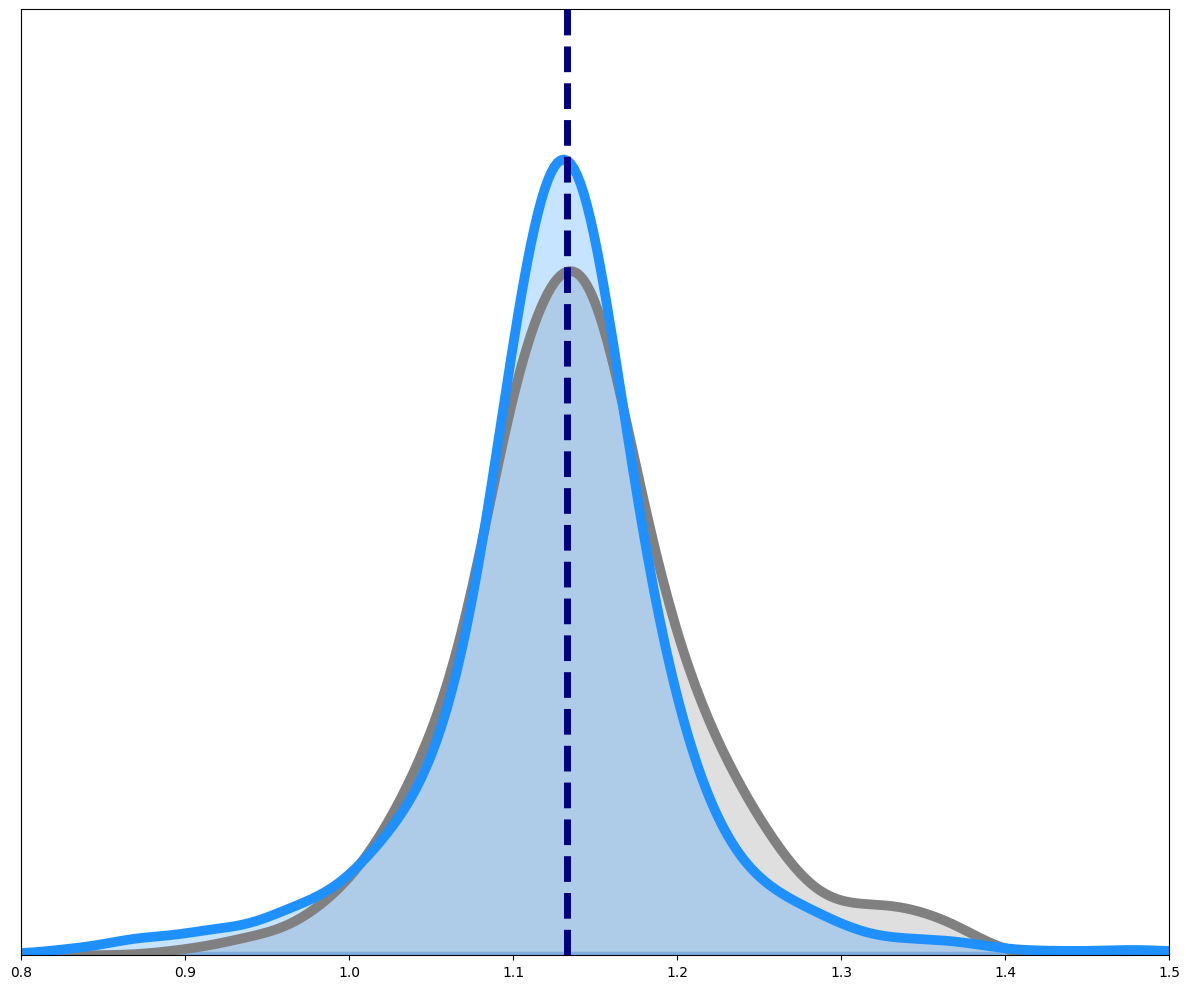

In [ ]:
# plot 1-D distribution estimate
plt.figure(figsize=(12, 10))
X = np.linspace(0, 2, 1000)
plt.plot(X, np.exp(KernelDensity(bandwidth=0.02)
                   .fit(p[sel].reshape(-1, 1))
                   .score_samples(X.reshape(-1, 1))),
         lw=7, color='gray')
plt.fill_between(X, np.exp(KernelDensity(bandwidth=0.02)
                           .fit(p[sel].reshape(-1, 1))
                           .score_samples(X.reshape(-1, 1))),
                 lw=5, color='gray', alpha=0.25)
plt.plot(X, np.exp(KernelDensity(bandwidth=0.02)
                   .fit(p_postpred.reshape(-1, 1))
                   .score_samples(X.reshape(-1, 1))),
         lw=7, color='dodgerblue')
plt.fill_between(X, np.exp(KernelDensity(bandwidth=0.02)
                           .fit(p_postpred.reshape(-1, 1))
                           .score_samples(X.reshape(-1, 1))),
                 lw=5, color='dodgerblue', alpha=0.25)
plt.vlines(wmean_post[-1], 0, 9, color='navy', lw=5, ls='dashed', zorder=10)
plt.xlim([0.8, 1.5])
plt.ylim([0, 9])
plt.yticks([])
plt.tight_layout()
#plt.savefig('data_postpred.png', bbox_inches='tight')

The distribution of parallax measurements from the data (gray) is compared to the simulated values from the posterior predictive (light blue). The posterior mean is indicated using the dashed dark blue line. The distributions appear relatively consistent with each other, at least by eye.

In [ ]:
# define quantiles (percentiles = quantiles * 100)
percentiles = np.arange(1, 100, 1)

# compute data quantiles
pct_data = np.percentile(p[sel], percentiles)
pct_post = np.percentile(p_postpred, percentiles)

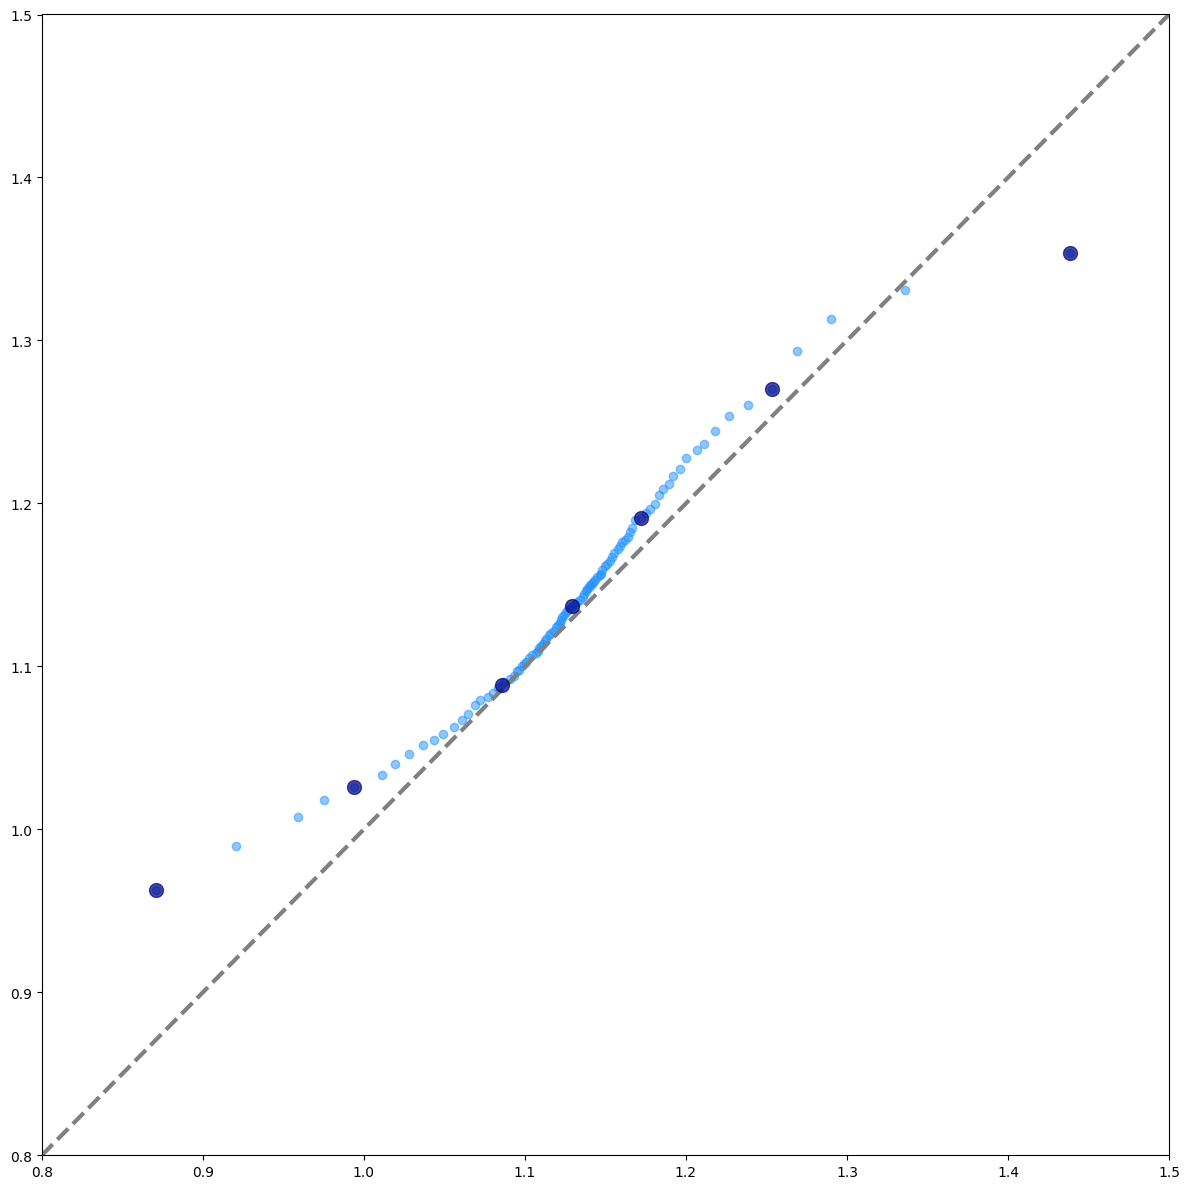

In [ ]:
# plot quantile-quantile comparison for a few posterior predictive samples
plt.figure(figsize=(12, 12))
plt.plot(pct_post, pct_data, 'o', color='dodgerblue', alpha=0.5, lw=3)
plt.plot(np.interp([1, 5, 20, 50, 80, 95, 99], percentiles, pct_post),
         np.interp([1, 5, 20, 50, 80, 95, 99], percentiles, pct_data),
         marker='o', markersize=10, alpha=0.7, ls='none', color='navy', zorder=10)
plt.plot([0.8, 1.5], [0.8, 1.5], ls='--', lw=3, color='gray')
plt.xlim([0.8, 1.5])
plt.ylim([0.8, 1.5])
plt.tight_layout()
#plt.savefig('data_postpred_qq.png', bbox_inches='tight')

The so-called *(Q-Q) plot* might be more informative. Here we see the Q-Q plot of the quantiles from the posterior predictive simulated parallax data (x-axis) and of the observed parallaxes (y-axis). If the real and simulated data followed the same distribution, then the quantiles would lie on the one-to-one line.
However, strong discrepancies are apparent below $\sim$ 10th percentile and above $\sim$ 70th percentile.

It would be worth investigating whether these differences persist under different models, for example one in which the distance to each star is not assumed to be identical, or a model in which measurement uncertainty is not assumed to be known exactly.